<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/%EF%BC%91DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-series Anomaly Detection with 1D-CNN Autoencoder (No LSTM)
 - 1D-CNN AE: window(L) を再構成 -> window MSE -> point-level score(max) -> 閾値(検証分位) -> persistence

In [3]:
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
# ---- 乱数・デバイス ----
np.random.seed(7); torch.manual_seed(7)
torch.set_num_threads(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

In [4]:
# -----------------------------
# 1) 正常系列の生成 & テストに異常注入
# -----------------------------
N = 3000
t = np.arange(N)
# 正常：2つのサイン + ノイズ
base = 0.9*np.sin(2*np.pi*t/60) + 0.35*np.sin(2*np.pi*t/15) + 0.15*np.random.randn(N)
signal = base.copy()

# ground-truth 異常マスク（True が異常）
gt = np.zeros(N, dtype=bool)

# テスト区間(2000:3000)に異常を注入
# spikes
for idx, amp in [(2200, 2.7), (2300, -2.9), (2210, 1.2), (2220, 1.2), (2232, 1.1)]:
    signal[idx] += amp; gt[idx] = True
# local high-frequency
s1, e1 = 2350, 2410
seg = np.arange(e1 - s1)
signal[s1:e1] += 0.9*np.sin(2*np.pi*seg/6) + 0.25*np.random.randn(e1 - s1)
gt[s1:e1] = True
# level shift
s2, e2 = 2665, 2745
signal[s2:e2] += np.linspace(0.0, 2.2, e2 - s2) + 0.15*np.random.randn(e2 - s2)
gt[s2:e2] = True

In [5]:
# -----------------------------
# 2) 窓化（AE：過去L点→L点をそのまま再構成）
# -----------------------------
L = 64  # ウィンドウ長
def to_windows(x, L):
    X = []
    for i in range(len(x) - L + 1):
        X.append(x[i:i+L])
    return np.array(X, np.float32)  # [Nwin, L]

# 区間：Train(0..1799), Val(1800..1999), Test(2000..2999)
X_tr = to_windows(signal[:1800], L)
X_va = to_windows(signal[1800:2000], L)
X_te = to_windows(signal[2000:], L)   # [Nte_win, L]

# 1D-CNN 用に [B, C=1, T=L] へ
def to_loader(X, bs=256, shuffle=False):
    X = torch.from_numpy(X)[:, None, :]  # [B, 1, L]
    ds = TensorDataset(X, X)             # AE は入力=出力
    return DataLoader(ds, batch_size=bs, shuffle=shuffle)

train_loader = to_loader(X_tr, bs=256, shuffle=True)
val_loader   = to_loader(X_va, bs=256, shuffle=False)


In [6]:
# -----------------------------
# 3) 1D-CNN Autoencoder（畳み込みのみ）
# -----------------------------
class CNN1dAE(nn.Module):
    def __init__(self, L=64):
        super().__init__()
        # Encoder: Conv -> ReLU -> Conv -> ReLU -> Conv -> ReLU
        self.enc = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, padding=2, stride=2),  # 長さ L/2
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, padding=2, stride=2),  # 長さ L/4
            nn.ReLU(),
        )
        # Decoder: ConvTranspose で元の長さへ
        self.dec = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),  # L/2
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),  # L
            nn.ReLU(),
            nn.Conv1d(16, 1, kernel_size=5, padding=2)  # 出力 [B,1,L]
        )
    def forward(self, x):
        z = self.enc(x)
        y = self.dec(z)
        return y

model = CNN1dAE(L=L).to(device)

In [7]:
# -----------------------------
# 4) 学習（正常のみ）
# -----------------------------
crit = nn.MSELoss()
opt  = optim.Adam(model.parameters(), lr=2e-3)

def run_epoch(loader, train=True):
    loss_sum = 0.0
    if train: model.train()
    else:     model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        if train: opt.zero_grad()
        yhat = model(xb)
        loss = crit(yhat, yb)
        if train:
            loss.backward(); opt.step()
        loss_sum += loss.item()
    return loss_sum / len(loader)

EPOCHS = 8  # CPUでも動く程度
for ep in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, True)
    va = run_epoch(val_loader, False)
    print(f"epoch {ep}/{EPOCHS}  train={tr:.5f}  val={va:.5f}")

epoch 1/8  train=0.48436  val=0.44191
epoch 2/8  train=0.28080  val=0.12714
epoch 3/8  train=0.11553  val=0.09417
epoch 4/8  train=0.08470  val=0.06617
epoch 5/8  train=0.05792  val=0.04990
epoch 6/8  train=0.04235  val=0.03816
epoch 7/8  train=0.03488  val=0.03451
epoch 8/8  train=0.03105  val=0.03062


In [8]:
# -----------------------------
# 5) 復元誤差 → window score → point score（max 集約）
# -----------------------------
@torch.no_grad()
def window_mse(X):
    model.eval()
    X_t = torch.from_numpy(X)[:, None, :].to(device)        # [N,1,L]
    Yhat = model(X_t).cpu().numpy()[:, 0, :]                 # [N,L]
    mse  = ((Yhat - X)**2).mean(axis=1)                     # window MSE
    return mse, Yhat

val_win_score, _  = window_mse(X_va)
test_win_score, _ = window_mse(X_te)

def win2point_max(win_score, series_len, L):
    # 各ウィンドウ i は [i, i+L) を覆う → その区間に window のMSEを「最大」で投影
    point = np.zeros(series_len, dtype=np.float32)
    for i in range(len(win_score)):
        s, e = i, min(series_len, i+L)
        point[s:e] = np.maximum(point[s:e], win_score[i])
    return point

series_len_test = 1000  # 2000..2999 の長さ
point_test = win2point_max(test_win_score, series_len_test, L)

# 閾値：検証ウィンドウ・スコアの上位分位（調整可）
thr = np.quantile(val_win_score, 0.995)

# persistence（連続 k 点以上で確定）
k = 4
above = point_test > thr
det_local = np.zeros_like(above, dtype=bool)
run = 0; start = 0
for i, flag in enumerate(above):
    if flag:
        if run == 0: start = i
        run += 1
    else:
        if run >= k: det_local[start:i] = True
        run = 0
if run >= k: det_local[start:len(above)] = True

# ローカル(0..999) → 全体(2000..2999)
det_mask = np.zeros(N, dtype=bool)
det_mask[2000:3000] = det_local


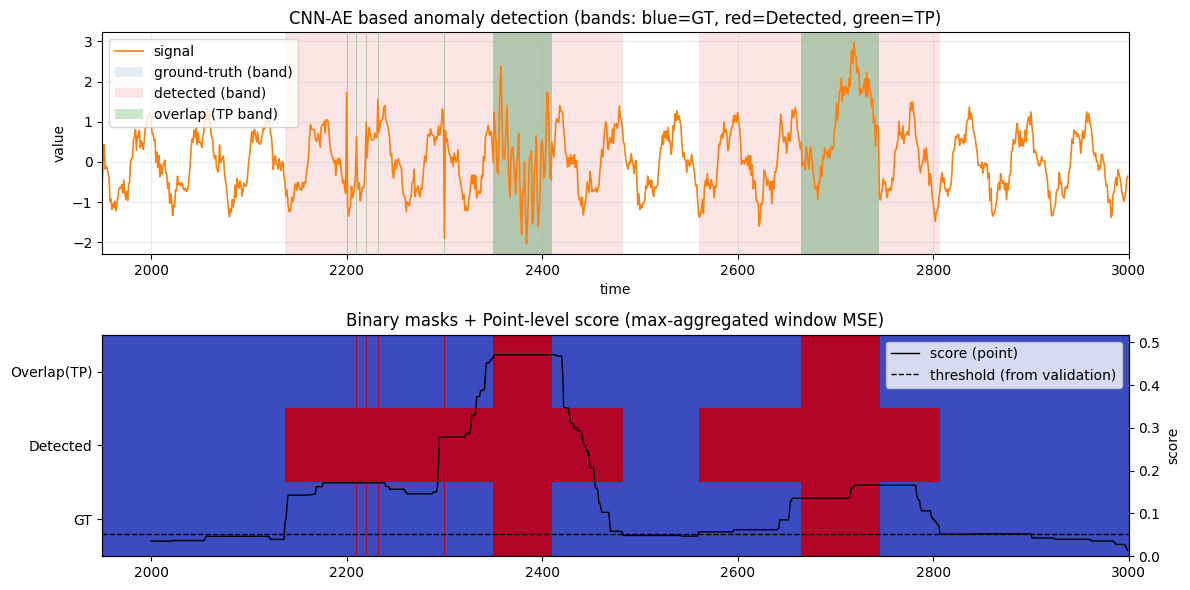

In [9]:
# -----------------------------
# 6) 可視化：上=signal + bands、下=マスク3段 + point score
# -----------------------------
lo, hi = 1950, 3000

def draw_spans(ax, mask, color, alpha=0.18):
    i = lo
    while i < hi:
        if mask[i]:
            j = i+1
            while j < hi and mask[j]: j += 1
            ax.axvspan(i, j, color=color, alpha=alpha, linewidth=0)
            i = j
        else:
            i += 1

plt.figure(figsize=(12, 6))

# 上段：signal と縦帯（GT/Detected/Overlap）
ax1 = plt.subplot(2,1,1)
line_signal, = ax1.plot(t[lo:hi], signal[lo:hi], color="tab:orange", lw=1.2, label="signal")
gt_band   = gt.copy()
det_band  = det_mask.copy()
over_band = gt_band & det_band
draw_spans(ax1, gt_band,   color='tab:blue',  alpha=0.12)
draw_spans(ax1, det_band,  color='tab:red',   alpha=0.12)
draw_spans(ax1, over_band, color='tab:green', alpha=0.25)

handles = [
    line_signal,
    Patch(facecolor='tab:blue',  alpha=0.12, label='ground-truth (band)'),
    Patch(facecolor='tab:red',   alpha=0.12, label='detected (band)'),
    Patch(facecolor='tab:green', alpha=0.25, label='overlap (TP band)'),
]
ax1.legend(handles=handles, loc="upper left")
ax1.set_title("CNN-AE based anomaly detection (bands: blue=GT, red=Detected, green=TP)")
ax1.set_xlabel("time"); ax1.set_ylabel("value"); ax1.grid(True, alpha=0.25)

# 下段：3段マスク + point score
ax2 = plt.subplot(2,1,2, sharex=ax1)
band = np.vstack([gt[lo:hi].astype(int), det_mask[lo:hi].astype(int), (gt & det_mask)[lo:hi].astype(int)])
ax2.imshow(band, aspect='auto', interpolation='nearest', extent=[lo, hi, 0, 3], cmap='coolwarm', vmin=0, vmax=1)
ax2.set_yticks([0.5, 1.5, 2.5]); ax2.set_yticklabels(["GT", "Detected", "Overlap(TP)"])
ax2.set_title("Binary masks + Point-level score (max-aggregated window MSE)")
# 右軸: point score と閾値
ax3 = ax2.twinx()
ax3.plot(np.arange(2000,3000), point_test, color='k', lw=1.0, label='score (point)')
ax3.axhline(thr, color='k', ls='--', lw=1.0, label='threshold (from validation)')
ax3.set_ylim(0, max(point_test.max(), thr)*1.1)
ax3.set_ylabel("score")
ax3.legend(loc="upper right")

plt.tight_layout(); plt.show()
